# **Assignment 3 - RRN - Weather Time Series Forcasting**

# **Name: Nisha Chaurasia**

# **Date: 11-04-2023**

**A temperature-forecasting example- Data Upload from mazon Web Services (AWS) /keras**

In [1]:
!pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 115.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 48.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-04 19:56:10--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.106.102, 52.217.236.160, 52.217.98.174, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.106.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  7.01MB/s    in 1.8s    

2023-11-04 19:56:13 (7.01 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset - 420451 rows and 15 Features**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Parsing the data- converting the comma-separated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis.**

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

Text(0, 0.5, 'Temperature')

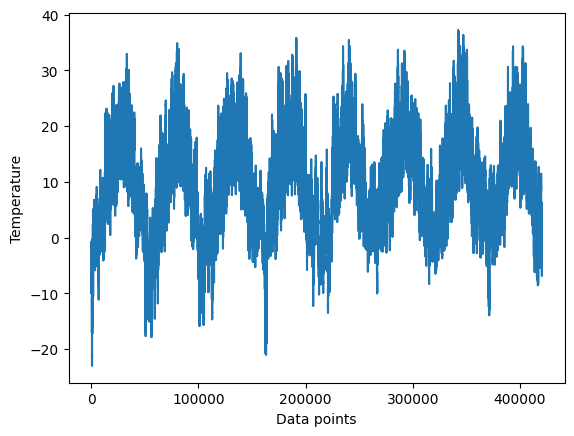

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Plotting the first 10 days of the temperature timeseries- As given that one day data has 144 data points hence 10days will have 1440 data points**

Text(0, 0.5, 'Temperature')

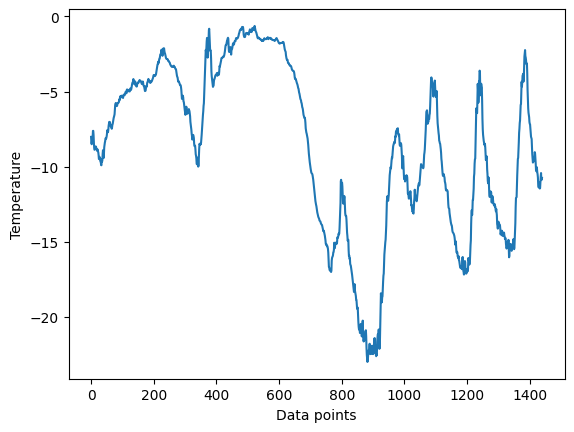

In [6]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Computing the number of samples we'll use for each data split- 50% for Train, 25%- validation**

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Normalizing the data- Since the data is already in a numerical format, vectorization is unnecessary. However, given that the data scales differ across variables, with temperature ranging from -20 to +30 and pressure measured in millibars, it is advisable to standardize all variables.**

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing - it is required because the samples in the dataset are highly redundant Hence, it would be inefficient to allocate memory for each sample explicitly. Instead, we will generate the samples dynamically.**

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **A common-sense, non-machine-learning baseline**

**Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.**

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Common-sense baseline approach is to predict that the temperature 24 hours ahead will be identical to the current temperature. By using this straightforward baseline, the validation MAE (Mean Absolute Error) is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. In other words, assuming that the temperature in the future remains the same as the current temperature would result in an average deviation of approximately two and a half degrees.

### **A basic machine-learning model - Dense Layer**

**Training and evaluating a densely connected model**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [15]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 19s 18ms/step - loss: 14.8665 - mae: 2.9710 - val_loss: 11.8763 - val_mae: 2.7361
Epoch 2/10
819/819 [==============================] - 14s 18ms/step - loss: 9.9812 - mae: 2.4854 - val_loss: 11.5712 - val_mae: 2.6979
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 9.1249 - mae: 2.3742 - val_loss: 11.3325 - val_mae: 2.6636
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 8.5410 - mae: 2.2963 - val_loss: 10.7137 - val_mae: 2.6037
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 8.0932 - mae: 2.2380 - val_loss: 11.4860 - val_mae: 2.7037
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 7.8562 - mae: 2.2059 - val_loss: 10.5439 - val_mae: 2.5889
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 7.6442 - mae: 2.1790 - val_loss: 11.9887 - val_mae: 2.7710
Epoch 8/10
819/819 [==============================] - 

In [17]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 5s 11ms/step - loss: 12.6385 - mae: 2.7914
Test MAE: 2.79


**Plotting results**

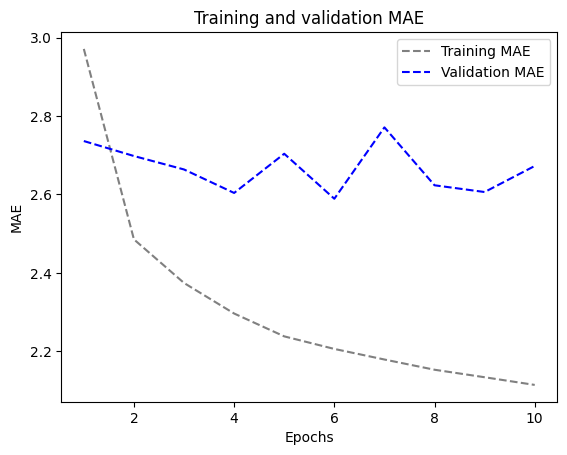

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **Let's try a 1D convolutional model**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 19ms/step - loss: 23.0920 - mae: 3.7301 - val_loss: 19.7132 - val_mae: 3.4955
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 15.4921 - mae: 3.1234 - val_loss: 15.0825 - val_mae: 3.0532
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 14.1145 - mae: 2.9793 - val_loss: 14.8547 - val_mae: 3.0428
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 13.2864 - mae: 2.8924 - val_loss: 14.9353 - val_mae: 3.0460
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 12.6836 - mae: 2.8196 - val_loss: 15.7066 - val_mae: 3.1272
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 12.1909 - mae: 2.7657 - val_loss: 15.9789 - val_mae: 3.1343
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 11.7977 - mae: 2.7199 - val_loss: 15.5569 - val_mae: 3.0953
Epoch 8/10
819/819 [============================

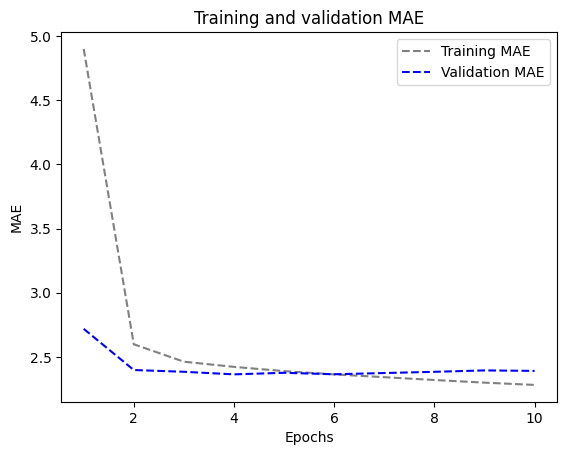

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

*It seem that the convolutional data perform worse compared to common sense or dense model. it could be because*

*- The assumption of translation invariance does not hold well for weather data.*

*- The order of the data is crucial. Recent past data is significantly more informative for predicting the temperature of the following day compared to data from several days ago. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order.*






### **A first recurrent baseline**

**A simple LSTM-based model**

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 20ms/step - loss: 44.8970 - mae: 4.8988 - val_loss: 13.0220 - val_mae: 2.7185
Epoch 2/10
819/819 [==============================] - 16s 19ms/step - loss: 11.1755 - mae: 2.5983 - val_loss: 9.5434 - val_mae: 2.3977
Epoch 3/10
819/819 [==============================] - 15s 19ms/step - loss: 9.9266 - mae: 2.4625 - val_loss: 9.4141 - val_mae: 2.3840
Epoch 4/10
819/819 [==============================] - 16s 19ms/step - loss: 9.6004 - mae: 2.4222 - val_loss: 9.2621 - val_mae: 2.3640
Epoch 5/10
819/819 [==============================] - 16s 19ms/step - loss: 9.3565 - mae: 2.3891 - val_loss: 9.3439 - val_mae: 2.3761
Epoch 6/10
819/819 [==============================] - 16s 19ms/step - loss: 9.1799 - mae: 2.3637 - val_loss: 9.2937 - val_mae: 2.3646
Epoch 7/10
819/819 [==============================] - 16s 20ms/step - loss: 9.0339 - mae: 2.3419 - val_loss: 9.3063 - val_mae: 2.3742
Epoch 8/10
819/819 [==============================] - 16s 1

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **A Simple RNN**

### **1.An RNN layer that can process sequences of any length**

In [41]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 54s 65ms/step - loss: 139.3956 - mae: 9.7107 - val_loss: 143.9525 - val_mae: 9.8908
Epoch 2/10
819/819 [==============================] - 53s 65ms/step - loss: 136.4089 - mae: 9.5597 - val_loss: 143.8205 - val_mae: 9.8864
Epoch 3/10
819/819 [==============================] - 52s 64ms/step - loss: 136.3110 - mae: 9.5517 - val_loss: 143.6634 - val_mae: 9.8630
Epoch 4/10
819/819 [==============================] - 52s 63ms/step - loss: 136.2414 - mae: 9.5467 - val_loss: 143.6552 - val_mae: 9.8636
Epoch 5/10
819/819 [==============================] - 52s 64ms/step - loss: 136.1721 - mae: 9.5391 - val_loss: 143.6233 - val_mae: 9.8610
Epoch 6/10
819/819 [==============================] - 52s 64ms/step - loss: 136.1451 - mae: 9.5372 - val_loss: 143.6001 - val_mae: 9.8587
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 136.1175 - mae: 9.5334 - val_loss: 143.5383 - val_mae: 9.8517
Epoch 8/10
819/819 [==============

### **2.An RNN layer that returns only its last output step**

**An RNN layer that returns only its last output step**

In [47]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
818/819 [============================>.] - ETA: 0s - loss: 139.2156 - mae: 9.7116

KeyboardInterrupt: ignored

### **3.An RNN layer that returns its full output sequence**

In [50]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10


InvalidArgumentError: ignored

**Stacking RNN layers**

In [31]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### Going even further

## Summary